In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset


Dataset URL: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset
License(s): copyright-authors
 99% 196M/199M [00:09<00:00, 24.4MB/s]
100% 199M/199M [00:09<00:00, 21.6MB/s]


In [ ]:
!unzip iqothnccd-lung-cancer-dataset.zip

Archive:  iqothnccd-lung-cancer-dataset.zip
  inflating: Test cases/000001_03_01_088.png  
  inflating: Test cases/000017_02_01_016.png  
  inflating: Test cases/000019_01_01_021.png  
  inflating: Test cases/000019_02_01_025.png  
  inflating: Test cases/000019_03_01_025.png  
  inflating: Test cases/000020_01_01_066.png  
  inflating: Test cases/000020_02_01_062.png  
  inflating: Test cases/000020_03_01_134.png  
  inflating: Test cases/000020_03_01_166.png  
  inflating: Test cases/000020_03_01_212.png  
  inflating: Test cases/000020_04_01_116.png  
  inflating: Test cases/000020_04_01_143.png  
  inflating: Test cases/000020_04_01_159.png  
  inflating: Test cases/000021_01_01_016.png  
  inflating: Test cases/000021_02_01_068.png  
  inflating: Test cases/000021_03_01_012.png  
  inflating: Test cases/000021_03_01_017.png  
  inflating: Test cases/000021_04_01_090.png  
  inflating: Test cases/000027_01_01_113.png  
  inflating: Test cases/000027_02_01_105.png  
  inflating: Tes

# Lung Cancer Detection Using VGG16

**Description:**
Developed a robust Lung Cancer Detection system utilizing transfer learning with the VGG16 model to classify lung cancer cases from CT scan images. The project leverages the IQOTHNCCD Lung Cancer dataset to train the model, enhancing its ability to accurately differentiate between malignant, benign, and normal cases.

**Key Features:**
- **Transfer Learning with VGG16:** Utilized the pre-trained VGG16 model, applying transfer learning techniques to adapt it for lung cancer classification, significantly improving training efficiency and accuracy.
- **Dataset:** Utilized the IQOTHNCCD Lung Cancer dataset with the following distribution:
  - Malignant cases: 561
  - Normal cases: 416
  - Benign cases: 120
- **Model Training and Fine-Tuning:** Fine-tuned the VGG16 model to optimize its performance in detecting lung cancer, ensuring high accuracy and robustness across different case categories.
- **Evaluation and Validation:** Thoroughly evaluated the model using metrics such as accuracy, precision, recall, and F1-score to validate its effectiveness in clinical scenarios.

**Technologies Used:**
- Python
- TensorFlow/Keras
- VGG16
- IQOTHNCCD Lung Cancer Dataset
- OpenCV (for image processing and augmentation)

**Achievements:**
- Successfully implemented a lung cancer detection system with high accuracy, demonstrating proficiency in medical image analysis and deep learning techniques.
- Developed a practical tool with potential applications in medical diagnostics and patient care.
- Contributed to advancing healthcare technology through innovative use of machine learning.

**Link to Project Repository:** [GitHub](#)


#

In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
base_path = '/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
subfolders = os.listdir(base_path)
subfolders

['IQ-OTH_NCCD lung cancer dataset.txt',
 'Bengin cases',
 'Malignant cases',
 'Normal cases']

In [ ]:


base_path = '/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
subfolders = ['Bengin cases', 'Malignant cases', 'Normal cases']

def check_image_types(base_path, subfolders):
    image_types = defaultdict(int)

    for folder in subfolders:
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if os.path.isfile(os.path.join(folder_path, file_name)):
                    file_extension = os.path.splitext(file_name)[1].lower()
                    image_types[file_extension] += 1

    return image_types

image_types = check_image_types(base_path, subfolders)
print("Image types and counts:", image_types)


Image types and counts: defaultdict(<class 'int'>, {'.jpg': 1097})


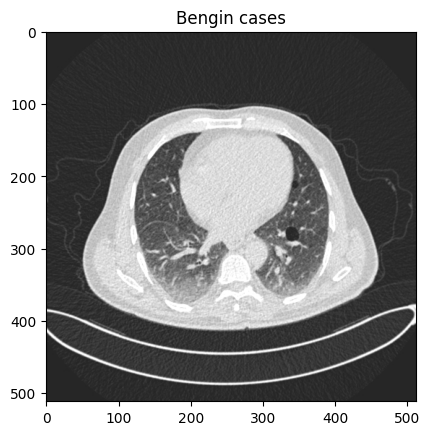

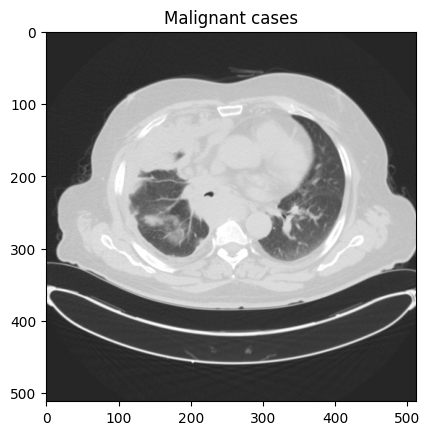

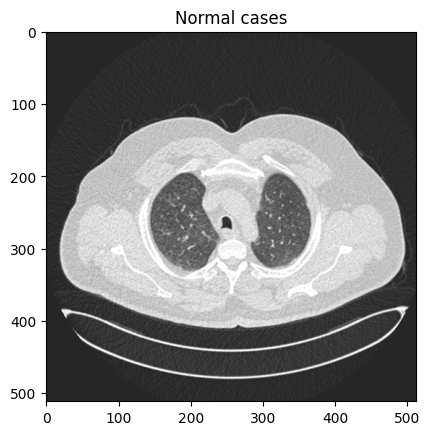

In [ ]:
# Function to print an image from each folder
def print_image_from_every_folder(base_path, subfolders):
    for folder in subfolders:
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if os.path.isfile(os.path.join(folder_path, file_name)):
                    image_path = os.path.join(folder_path, file_name)
                    image = plt.imread(image_path)
                    plt.imshow(image)
                    plt.title(folder)
                    plt.show()
                    break

print_image_from_every_folder(base_path, subfolders)


In [ ]:


size_data = {}
for i in subfolders:
    path = os.path.join(base_path, i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)
        if img is not None:
            height, width, channels = img.shape[:3]
            size_key = f"{height} x {width}"
            if size_key in temp_dict:
                temp_dict[size_key] += 1
            else:
                temp_dict[size_key] = 1

    size_data[i] = temp_dict

size_data


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

In [ ]:

# Function to count channels in an image
def count_channels(image_path):
    image = plt.imread(image_path)
    return image.shape[2]


In [ ]:
# Calculate class counts
class_counts = Counter()

for folder in subfolders:
    folder_path = os.path.join(base_path, folder)
    for file_name in os.listdir(folder_path):
        class_counts[folder] += 1

print("Class counts:", class_counts)

Class counts: Counter({'Malignant cases': 561, 'Normal cases': 416, 'Bengin cases': 120})


In [86]:
# Create DataFrames for images and labels
image_paths = []
labels = []

for folder in subfolders:
    folder_path = os.path.join(base_path, folder)
    label = folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            image_paths.append(file_path)
            labels.append(label)
df = pd.DataFrame({'img_path': image_paths, 'label': labels})

# Split DataFrame into train, validation, and test sets
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 767
Validation set size: 165
Test set size: 165


In [87]:
# Calculate class weights
y = df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

print("Class weight dictionary:", class_weight_dict)

Class weight dictionary: {0: 3.047222222222222, 1: 0.6518122400475341, 2: 0.8790064102564102}


In [ ]:
class_weight_dict

{0: 3.047222222222222, 1: 0.6518122400475341, 2: 0.8790064102564102}

In [88]:
# Image preprocessing and augmentation
IMG_WIDTH, IMG_HEIGHT = 224, 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

TEST_DATAGEN = ImageDataGenerator(rescale=1./255.)

train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col="img_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col="img_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col="img_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)


Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [89]:
# Define the model using VGG16 as base
base_model_vgg16 = VGG16(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights="imagenet")


In [90]:

for layer in base_model_vgg16.layers:
    layer.trainable = False

model = Sequential()
model.add(Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(base_model_vgg16)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(3, activation="softmax"))

model.compile(optimizer=Adam(0.0005), loss="categorical_crossentropy", metrics=["accuracy"])


In [91]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 40408899 (154.15 MB)
Trainable params: 25694211 (98.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [93]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/50
24/24 [==============================] - 14s 567ms/step - loss: 1.3851 - accuracy: 0.5476 - val_loss: 1.3689 - val_accuracy: 0.3818 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 13s 515ms/step - loss: 0.8623 - accuracy: 0.6610 - val_loss: 0.6170 - val_accuracy: 0.6727 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 12s 503ms/step - loss: 0.6273 - accuracy: 0.7588 - val_loss: 0.5038 - val_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 13s 536ms/step - loss: 0.5324 - accuracy: 0.8005 - val_loss: 0.4310 - val_accuracy: 0.8242 - lr: 5.0000e-04
Epoch 5/50
24/24 [==============================] - 13s 537ms/step - loss: 0.5797 - accuracy: 0.7718 - val_loss: 0.4150 - val_accuracy: 0.8667 - lr: 5.0000e-04
Epoch 6/50
24/24 [==============================] - 13s 530ms/step - loss: 0.4919 - accuracy: 0.8266 - val_loss: 0.3466 - val_accuracy: 0.8848 - lr: 5.0000e-04
Epoch 7/50
24/24 [======================

In [94]:
# Define a custom CNN model
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

In [95]:
model2.summary()

model2.compile(optimizer=Adam(0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the custom CNN model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    callbacks=[reduce_lr],
    class_weight=class_weight_dict
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 activation_2 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 186624)          

In [96]:
# Save the entire VGG16 model
model.save('lung_cancer_model_vgg162.keras')

In [98]:
# Parameters
img_size = 224  # The input size for the model (VGG16)
test_folder_path = '/content/Test cases'  # Path to the folder containing test images

# Function to load and preprocess images
def preprocess_images_from_folder(folder_path, img_size):
    images = []
    filenames = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
            img = cv2.resize(img, (img_size, img_size))  
            img = img / 255.0  
            images.append(img)
            filenames.append(filename)

    images = np.array(images)
    return images, filenames

# Preprocess the images
X_test, test_filenames = preprocess_images_from_folder(test_folder_path, img_size)

# Print shapes to verify
print("Shape of preprocessed test images:", X_test.shape)

Shape of preprocessed test images: (197, 224, 224, 3)


In [99]:
# Make predictions on the test images
predictions = model.predict(X_test)

# Convert the predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Optionally, map the class indices to class labels if you have a mapping
class_mapping = {0: 'Bengin', 1: 'Malignant', 2: 'Normal'}  # Adjust based on your class mapping

# Create a dictionary to store filenames and their predicted labels
results = {filename: class_mapping[class_index] for filename, class_index in zip(test_filenames, predicted_classes)}

# Print the results
for filename, label in results.items():
    print(f"Filename: {filename}, Predicted Label: {label}")

# Optionally, save the results to a CSV file
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=['Filename', 'Predicted Label'])
results_df.to_csv('predictions2.csv', index=False)

7/7 [==============================] - 1s 144ms/step
Filename: 000207_04_01_068.png, Predicted Label: Normal
Filename: 000247_04_01_165.png, Predicted Label: Normal
Filename: 000058_06_02_177.png, Predicted Label: Malignant
Filename: 000188_02_01_157.png, Predicted Label: Normal
Filename: 000196_03_02_173.png, Predicted Label: Malignant
Filename: 000058_07_01_218.png, Predicted Label: Normal
Filename: 000103_13_02_092.png, Predicted Label: Malignant
Filename: 000207_04_01_191.png, Predicted Label: Normal
Filename: 000207_04_01_059.png, Predicted Label: Normal
Filename: 000230_05_01_165.png, Predicted Label: Normal
Filename: 000143_05_01_116.png, Predicted Label: Malignant
Filename: 000198_05_01_124.png, Predicted Label: Normal
Filename: 002276_05_03_078.png, Predicted Label: Normal
Filename: 000231_02_01_042.png, Predicted Label: Normal
Filename: 000065_06_01_030.png, Predicted Label: Malignant
Filename: 000315_04_03_145.png, Predicted Label: Normal
Filename: 000103_06_01_131.png, Pred